In [1]:
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn import linear_model #линейные модели
from sklearn import metrics #метрики
from sklearn import preprocessing #предобработка
from sklearn.model_selection import train_test_split #разделение выборки
%matplotlib inline
plt.style.use('seaborn')


In [2]:
data = pd.read_csv('data/insurance.csv')
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


набор данных содержит следующие столбцы:

- age — возраст основного бенефициара;
- sex — пол страхового подрядчика;
- bmi — индекс массы тела (kг/м), в идеале — от 18.5 до 24.9;
- children — количество детей, охваченных медицинской страховкой;
- smoker — является ли человек курящим;
- region — жилой район США (северо-восток, юго-восток, северо-запад, юго-запад);
- charges (целевой признак) — индивидуальные медицинские расходы, оплачиваемые медицинской страховкой.

In [94]:
# Размер таблицы:
print(data.shape)

(1338, 7)


In [95]:
# информация о пропусках
display(data.isnull().sum())

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

Пропуски в таблице отсутствуют.

In [96]:
# Посмотрим на типы данных:
display(data.dtypes)

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

Наши данные содержат несколько типов признаков:

- age, bmi, children — числовые признаки;
- sex, smoker — бинарные категориальные переменные (две категории);
- region — множественные категориальные переменные (несколько категорий);
- charges — числовой целевой признак.

In [97]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [98]:
data.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [99]:
data.describe(include='object')

,sex,smoker,region
count,1338,1338,1338
unique,2,2,4
top,male,no,southeast
freq,676,1064,364


In [3]:
#Создаем копию данных для облегчения работы с изменениями в таблице
temp_data = data.copy()

Прежде чем приступать к этапу подготовки данных для модели, вы можете произвести небольшое исследование зависимостей в данных, например построить следующие графики и диаграммы:

- гистограммы/коробчатые диаграммы числовых признаков;
- столбчатые диаграммы медианных медицинских расходов в зависимости от категориальных признаков;
- диаграммы рассеяния зависимости целевого признака от других числовых в разрезе категориальных (обратите особенное внимание на зависимость медицинских расходов от признака курения).

Проведем небольшое исследование зависимости целевого признака charge от числовых признаков.

In [4]:
#выделяем имена числовых признаков в виде списка для удобства дальнейшей работы
types = temp_data.dtypes
num_features = list(types[(types != 'object')].index)
num_features

['age', 'bmi', 'children', 'charges']

Для каждого числового признака построим гистограмму признаки и диаграмму рассеяния, иллюстрирующую зависимость целевого признака от каждого из факторов. Дополнительно поверх диаграммы рассеяния построим уравнение линейной регрессии. 

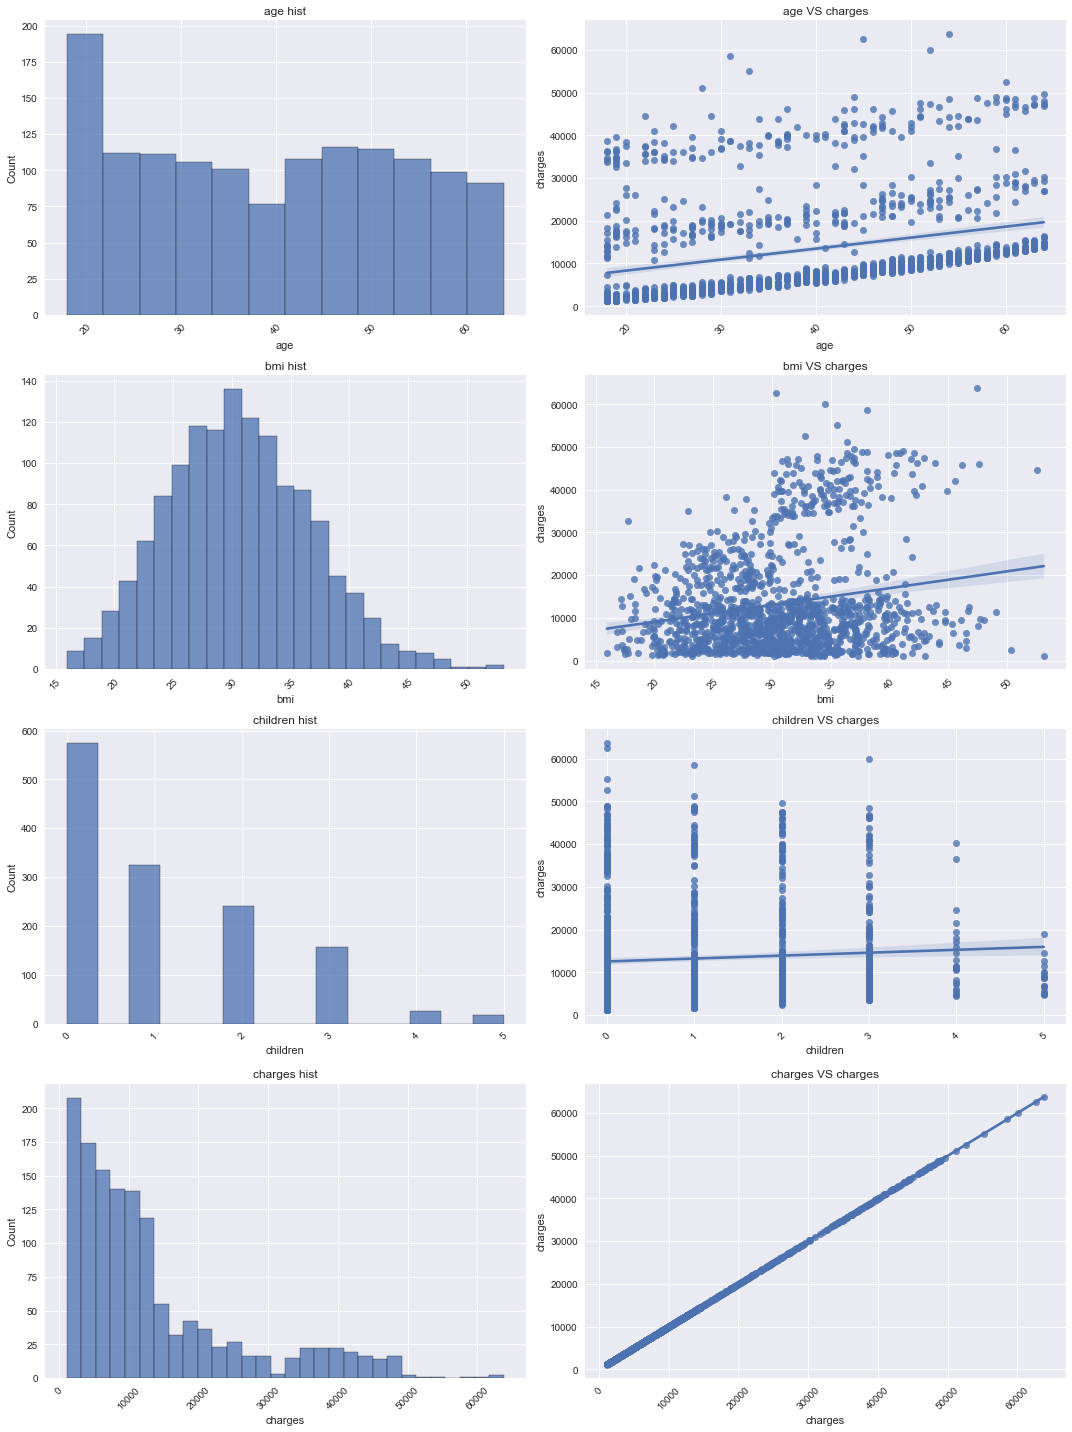

In [102]:
n = len(num_features) #количество числовых признаков
fig, axes = plt.subplots(n, 2, figsize=(15, 20)) # фигура + n х 2 координатных плоскостей
#Создаем цикл для всех признаков из списка числовых признаков
for i, feature in enumerate(num_features): #i- индекс, feature - название признака в таблице
    #Строим гистограмму распределения признака 
    histplot = sns.histplot(data=temp_data, x=feature, ax=axes[i][0])
    #Добавляем подпись графику
    histplot.set_title('{} hist'.format(feature))
    #Добавляем поворот отметок на оси абсцисс
    histplot.xaxis.set_tick_params(rotation=45)
    #Строим диаграмму рассеяния + линейную регрессию
    regplot = sns.regplot(data=temp_data, x=feature, y='charges', ax=axes[i][1])
    #Добавляем подпись графику
    regplot.set_title('{} VS charges'.format(feature));
    #Добавляем поворот отметок на оси абсцисс
    regplot.xaxis.set_tick_params(rotation=45)
plt.tight_layout() #выравнивание графиков

Строим тепловую карту для корреляционной матрицы, чтобы оценить мультиколлинеарную зависимость и линейную взаимосвязь между факторами и целевым признаком (price)

Мы знаем, что модель линейной регрессии не умеет работать с категориальными признаками, поэтому категории необходимо перекодировать.

Кодировку будем совершать по следующему принципу:

- smoker — переведём в бинарные значения (0 — некурящий, 1 — курящий);
- sex — аналогично (0 — female, 1 — male);
- region — используем OneHot-кодирование (воспользуемся функцией get_dummies).

In [10]:

#кодируем бинарные категориальные признаки
data['smoker'] = data['smoker'].apply(lambda x: 0 if x == 'no' else 1)
data['sex'] = data['sex'].apply(lambda x: 0 if x == 'female' else 1)
#оставшиеся категориальные признаки кодируем с помощью OneHot
data = pd.get_dummies(data)
data.head()

,age,sex,bmi,children,smoker,charges,region_northeast,region_northwest,region_southeast,region_southwest
0,19,0,27.900,0,1,16884.92400,0,0,0,1
1,18,1,33.770,1,0,1725.55230,0,0,1,0
2,28,1,33.000,3,0,4449.46200,0,0,1,0
3,33,1,22.705,0,0,21984.47061,0,1,0,0
4,32,1,28.880,0,0,3866.85520,0,1,0,0


In [104]:
temp_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               1338 non-null   int64  
 1   bmi               1338 non-null   float64
 2   children          1338 non-null   int64  
 3   charges           1338 non-null   float64
 4   sex_female        1338 non-null   uint8  
 5   sex_male          1338 non-null   uint8  
 6   smoker_no         1338 non-null   uint8  
 7   smoker_yes        1338 non-null   uint8  
 8   region_northeast  1338 non-null   uint8  
 9   region_northwest  1338 non-null   uint8  
 10  region_southeast  1338 non-null   uint8  
 11  region_southwest  1338 non-null   uint8  
dtypes: float64(2), int64(2), uint8(8)
memory usage: 52.4 KB


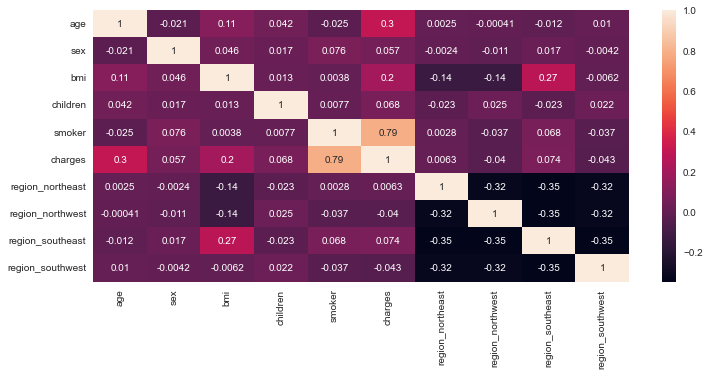

In [11]:
#строим тепловую карту корреляций
fig = plt.figure(figsize=(12, 5))
sns.heatmap(data.corr(), annot=True);

Видна сильная корреляционная зависимость медицинских расходов от признака курения

## Задание 6.1
Прежде чем переходить к этапу моделирования, нам необходимо позаботиться о создании выборки для тестирования модели.

Разделите набор данных на тренировочную и тестовую выборки в соотношении 80/20. Воспользуйтесь функцией train_test_split.

В качестве значения параметра random_state укажите число 42.

Чему равно количество наблюдений в тестовом наборе данных?

### ответ:
- А) Разделим набор данных на матрицу наблюдений X (таблица из объектов и их признаков) и столбец правильных ответов y

In [12]:
features = data.drop('charges', axis=1).columns
X, y = data[features], data['charges']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
print('Train:', X_train.shape)
print('Test:', X_test.shape)

Train: (1070, 9)
Test: (268, 9)


правильный ответ на вопрос Чему равно количество наблюдений в тестовом наборе данных? - 268

### Задание 6.2
Обучите модель линейной регрессии аналитическим методом (LinearRegression) на тренировочном наборе данных. Все параметры оставьте по умолчанию.

Чему равен свободный член (intercept) обученной модели? Ответ округлите до сотых.

In [13]:
lr_model = linear_model.LinearRegression()
lr_model.fit(X_train, y_train)
print('Свободный член (intercept) обученной модели равен {:.2f}'.format(lr_model.intercept_))
#print(np.round(lr_model.intercept_, 2))

#y_train_predict = lr_model.predict(X_train)
#y_test_predict = lr_model.predict(X_test)

Свободный член (intercept) обученной модели равен -12390.80


In [14]:
def print_metrics(y_train, y_train_predict, y_test, y_test_predict):
    print('Train R^2: {:.3f}'.format(metrics.r2_score(y_train, y_train_predict)))
    print('Train MAE: {:.0f}'.format(metrics.mean_absolute_error(y_train, y_train_predict)))
    print('Train MAPE: {:.0f}'.format(metrics.mean_absolute_percentage_error(y_train, y_train_predict)*100))
    print('\n')
    print('Test R^2: {:.3f}'.format(metrics.r2_score(y_test, y_test_predict)))
    print('Test MAE: {:.0f}'.format(metrics.mean_absolute_error(y_test, y_test_predict)))
    print('Test MAPE: {:.0f}'.format(metrics.mean_absolute_percentage_error(y_test, y_test_predict)*100))

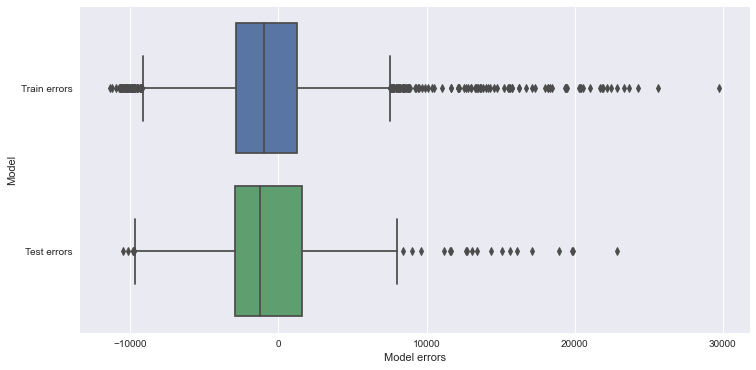

In [15]:
#Визуализируем ошибки
fig, ax = plt.subplots(figsize=(12, 6)) #фигура + координатная плоскость
#Ошибки модели на тренировочной выборке 
y_train_errors = y_train - lr_model.predict(X_train)
#Ошибки модели на тестовой выборке
y_test_errors = y_test - lr_model.predict(X_test)
#Для удобства визуализации составим DataFrame из ошибок
predict_df = pd.DataFrame(
    {'Train errors': y_train_errors, 
     'Test errors': y_test_errors
    }
)
#Строим boxplot для ошибок
sns.boxplot(data=predict_df, orient='h', ax=ax)
ax.set_xlabel('Model errors') #название оси абсцисс
ax.set_ylabel('Model'); #название оси ординат

In [16]:
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

poly = preprocessing.PolynomialFeatures(degree=2, include_bias=False)
poly.fit(X_train_scaled)
X_train_scaled_poly = poly.transform(X_train_scaled)
X_test_scaled_poly = poly.transform(X_test_scaled)
print(X_train_scaled_poly.shape)

(1070, 54)


In [17]:
lr_poly = linear_model.LinearRegression()
lr_poly.fit(X_train_scaled_poly, y_train)

y_train_predict = lr_poly.predict(X_train_scaled_poly)
y_test_predict = lr_poly.predict(X_test_scaled_poly)
print_metrics(y_train, y_train_predict, y_test, y_test_predict)

Train R^2: 0.842
Train MAE: 2873
Train MAPE: 29


Test R^2: 0.866
Test MAE: 2717
Test MAPE: 30


In [18]:
print(lr_poly.coef_)


[ 3.28425930e+16  5.24092415e+15 -3.54274027e+15  5.56107133e+15
 -4.36104954e+15 -4.32544728e+15 -1.27568697e+17 -1.54961145e+16
 -5.06580635e+16  8.44000000e+03  8.78000000e+02  8.20000000e+02
 -1.73200000e+03  1.84000000e+02 -3.28425930e+16 -3.28425930e+16
 -3.28425930e+16 -3.28425930e+16 -5.62830332e+16  7.20250000e+02
 -1.29050000e+03  2.70000000e+02  5.10421091e+16  5.10421091e+16
  5.10421091e+16  5.10421091e+16 -9.74062500e+03  1.60400000e+03
  5.48413125e+04  3.54274027e+15  3.54274027e+15  3.54274027e+15
  3.54274027e+15 -2.08000000e+03 -2.18400000e+03 -5.56107133e+15
 -5.56107133e+15 -5.56107133e+15 -5.56107133e+15 -2.08317967e+15
  6.44422921e+15  6.44422921e+15  6.44422921e+15  6.44422921e+15
 -1.82552363e+16  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.04988013e+17  0.00000000e+00  0.00000000e+00 -7.08456908e+15
  0.00000000e+00  2.80773799e+16]


In [19]:
lasso_lr_poly = linear_model.Lasso()
lasso_lr_poly.fit(X_train_scaled_poly, y_train)

y_train_predict = lasso_lr_poly.predict(X_train_scaled_poly)
y_test_predict = lasso_lr_poly.predict(X_test_scaled_poly)

print_metrics(y_train, y_train_predict, y_test, y_test_predict)

print(lasso_lr_poly.coef_)

Train R^2: 0.842
Train MAE: 2889
Train MAPE: 29


Test R^2: 0.867
Test MAE: 2718
Test MAPE: 30
[ 3254.29444013  -497.77667434  5082.44296811  4579.96903719
 11174.5885881     92.27997327  -474.0824118    585.76537158
  -243.94757338  8291.3159849    776.44311147   834.79828593
 -1211.25190072   133.7834509  -1044.725423      -0.
  1169.28596708  1614.02590931    -0.           511.03215486
 -1132.38078219   266.01794461 -1221.18415878     0.
   239.00186822  -577.34015094 -8185.15426742  1294.30664583
 54733.92609325  3582.81956575  2403.95450092  -968.57471909
    -0.         -1670.63577613 -2056.02514315  1943.04187366
  1954.4503939      0.         -1061.93641958 -8575.11156654
    -0.          -592.75085202  -851.52193562  1359.94923273
   723.55006857     0.             0.             0.
    -0.             0.             0.             0.
     0.            -0.        ]


c:\Users\79262\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.292e+09, tolerance: 1.544e+07
  model = cd_fast.enet_coordinate_descent(


Вывод: параметры пришли к нормальным значениям, что говорит об устойчивости модели.

In [20]:
ridge_lr_poly = linear_model.Ridge()
ridge_lr_poly.fit(X_train_scaled_poly, y_train)

y_train_predict = ridge_lr_poly.predict(X_train_scaled_poly)
y_test_predict = ridge_lr_poly.predict(X_test_scaled_poly)

print_metrics(y_train, y_train_predict, y_test, y_test_predict)

Train R^2: 0.839
Train MAE: 2949
Train MAPE: 30


Test R^2: 0.863
Test MAE: 2861
Test MAPE: 31
